In [1]:
import numpy as np
import pandas as pd
import time
import os
import pathlib

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import losses, optimizers
from tensorflow.keras.models import Sequential, load_model
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, Activation, Dense, TimeDistributed,Conv2D,MaxPooling2D, Lambda,UpSampling2D
from tensorflow.keras.layers import add, dot, concatenate, LSTM, Bidirectional,Reshape,Flatten
import tensorflow.keras as keras
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
#from tf.compat.v1.keras.layers.CuDNNLSTM
from Utils.PlotLosses import PlotLosses
from Utils.Utils import dist_coordinates, TrainModel, s_DataFrame, s_relative_and_std, euclidean_distance_loss,set_input,s_labels

K.clear_session()

In [2]:
std_coordinates = 260
std_orientation = 180

_n_hist = 10
_n_samples = 12

## Methods

In [3]:
def model_LSTM(size = []) :
    K.clear_session()
    
    history_input = Input(shape=(size[0]))
    observed_input = Input(shape=(size[1],))
    
    history_hidden1 = Bidirectional(LSTM(size[2], return_sequences = False),name ='History_Hidden1')(history_input)
    
    observed_hidden1 = Dense(size[3],activation='relu',name = 'Observer_Hidden1')(observed_input)
    
    concat_1 = concatenate([history_hidden1,observed_hidden1],axis = -1, name = 'Concatenate')    
    hidden1 = Dense(size[4], activation = 'relu', name = 'Concat-Hidden1')(concat_1)
        
    y_head = Dense(size[5], activation = 'tanh',name='Output_head')(hidden1) 
    y_orientation = Dense(size[6],activation = 'tanh',name='Output_orientation')(hidden1)

    _model = keras.Model(inputs=[history_input, observed_input], outputs=[y_head,y_orientation])
    print(_model.summary())
    
    return _model

# Model 1 : Using 1 teammate (ICRA model)

## inputs

In [4]:
path = './Data_v2.0/3Robots/TrainSet'
data_train = pd.read_csv(path+'/Train.csv')
data_test = pd.read_csv(path+'/Test.csv')
data_val = pd.read_csv(path+'/Val.csv')

robots = ['H','F1','T']
std_robot = 'T'
coordinates = ['x','y']
orientation = ['o']


In [5]:
_max = 0
for i in range(_n_samples) :
    _tmp = np.max(np.abs(data_train['{}_H_x'.format(i)]-data_train['{}_T_x'.format(i)]))
    if _tmp >= _max :
        _max = _tmp
print(_max)

253


In [6]:
train_data = s_relative_and_std(data = data_train, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1'])
val_data = s_relative_and_std(data = data_val, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1'])
test_data = s_relative_and_std(data = data_test, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1'])

In [7]:
_obs_list = ['_F1_x','_F1_y']
pred_list = ['_H_x','_H_y','_F1_o','_H_o']
step = 0
x_train = set_input(_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = train_data,data2 = train_data)
x_val = set_input(_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = val_data,data2 = val_data)
x_test = set_input(_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = test_data,data2 = test_data)

History : [['0_F1_x', '0_F1_y'], ['0_H_x', '0_H_y', '0_F1_o', '0_H_o'], []]
History : [['1_F1_x', '1_F1_y'], ['1_H_x', '1_H_y', '1_F1_o', '1_H_o'], []]
History : [['2_F1_x', '2_F1_y'], ['2_H_x', '2_H_y', '2_F1_o', '2_H_o'], []]
History : [['3_F1_x', '3_F1_y'], ['3_H_x', '3_H_y', '3_F1_o', '3_H_o'], []]
History : [['4_F1_x', '4_F1_y'], ['4_H_x', '4_H_y', '4_F1_o', '4_H_o'], []]
History : [['5_F1_x', '5_F1_y'], ['5_H_x', '5_H_y', '5_F1_o', '5_H_o'], []]
History : [['6_F1_x', '6_F1_y'], ['6_H_x', '6_H_y', '6_F1_o', '6_H_o'], []]
History : [['7_F1_x', '7_F1_y'], ['7_H_x', '7_H_y', '7_F1_o', '7_H_o'], []]
History : [['8_F1_x', '8_F1_y'], ['8_H_x', '8_H_y', '8_F1_o', '8_H_o'], []]
History : [['9_F1_x', '9_F1_y'], ['9_H_x', '9_H_y', '9_F1_o', '9_H_o'], []]
Observed : ['10_F1_x', '10_F1_y', '11_F1_x', '11_F1_y']
History : [['0_F1_x', '0_F1_y'], ['0_H_x', '0_H_y', '0_F1_o', '0_H_o'], []]
History : [['1_F1_x', '1_F1_y'], ['1_H_x', '1_H_y', '1_F1_o', '1_H_o'], []]
History : [['2_F1_x', '2_F1_y'],

## labels

In [8]:
_label_list = [['{}_H_x'.format(_n_hist),'{}_H_y'.format(_n_hist)],
            ['{}_F1_o'.format(_n_hist),'{}_F1_o'.format(_n_hist+1),'{}_H_o'.format(_n_hist)]]

y_train = s_labels(_label_list = _label_list, data = train_data)
y_val = s_labels(_label_list = _label_list, data = val_data)
y_test = s_labels(_label_list = _label_list, data = test_data)

In [9]:
print(_label_list)

[['10_H_x', '10_H_y'], ['10_F1_o', '11_F1_o', '10_H_o']]


## training

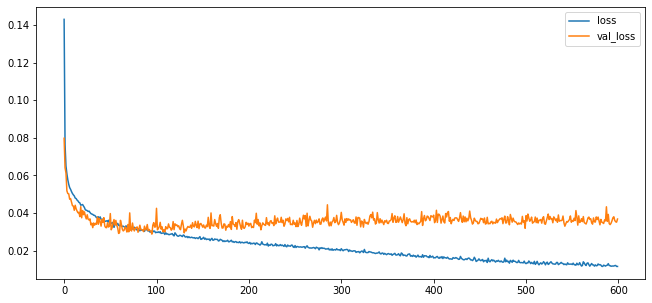


Epoch 00600: val_loss did not improve from 0.02876
10624/10624 [==============================] - 12s 1ms/sample - loss: 0.0116 - Output_head_loss: 0.0056 - Output_orientation_loss: 0.0060 - val_loss: 0.0368 - val_Output_head_loss: 0.0075 - val_Output_orientation_loss: 0.0293


In [10]:
size = [(10,6),4,160,80,160,2,3]
lr = 0.0003
epochs = 600

for i in range(0,1) :
    save_path = './SaveModels/Modified_Models/Model1_{}.h'.format(i)

    _model1 = model_LSTM(size)
    Model1,history1 = TrainModel(_model = _model1,save_path = save_path, lr = lr,epochs=epochs,
    #                             losses = ['mean_squared_error'],
                                 losses = [euclidean_distance_loss,'mean_squared_error'],
                                 train_x = x_train, train_y =y_train,
                                val_x = x_val, val_y =y_val )



# Model 2 : 2 teammates

### inputs

In [11]:
std_coordinates = 310
std_orientation = 180

_n_hist = 10
_n_samples = 13

In [12]:
path = './Data_v2.0/4Robots/TrainSet2'
data_train = pd.read_csv(path+'/Train.csv')
data_test = pd.read_csv(path+'/Test.csv')
data_val = pd.read_csv(path+'/Val.csv')

robots = ['H','F1','F2','T']
std_robot = 'T'
coordinates = ['x','y']
orientation = ['o']


In [13]:
_max = 0
for i in range(_n_samples) :
    _tmp = np.max(np.abs(data_train['{}_H_x'.format(i)]-data_train['{}_T_x'.format(i)]))
    if _tmp >= _max :
        _max = _tmp
print(_max)

301


In [14]:
train_data = s_relative_and_std(data = data_train, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F2'])
val_data = s_relative_and_std(data = data_val, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F2'])
test_data = s_relative_and_std(data = data_test, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F2'])

In [15]:
_obs_list = ['_F2_x','_F2_y','_F1_x','_F1_y']
pred_list = ['_H_x','_H_y','_H_o','_F1_o','_F2_o']
step = 0
x_train = set_input(timedifference=[1,1,0,0],_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = train_data,data2 = train_data)
x_val = set_input(timedifference=[1,1,0,0],_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = val_data,data2 = val_data)
x_test = set_input(timedifference=[1,1,0,0],_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = test_data,data2 = test_data)

History : [['0_F2_x', '0_F2_y', '0_F1_x', '0_F1_y'], ['0_H_x', '0_H_y', '0_H_o', '0_F1_o', '0_F2_o'], []]
History : [['1_F2_x', '1_F2_y', '1_F1_x', '1_F1_y'], ['1_H_x', '1_H_y', '1_H_o', '1_F1_o', '1_F2_o'], []]
History : [['2_F2_x', '2_F2_y', '2_F1_x', '2_F1_y'], ['2_H_x', '2_H_y', '2_H_o', '2_F1_o', '2_F2_o'], []]
History : [['3_F2_x', '3_F2_y', '3_F1_x', '3_F1_y'], ['3_H_x', '3_H_y', '3_H_o', '3_F1_o', '3_F2_o'], []]
History : [['4_F2_x', '4_F2_y', '4_F1_x', '4_F1_y'], ['4_H_x', '4_H_y', '4_H_o', '4_F1_o', '4_F2_o'], []]
History : [['5_F2_x', '5_F2_y', '5_F1_x', '5_F1_y'], ['5_H_x', '5_H_y', '5_H_o', '5_F1_o', '5_F2_o'], []]
History : [['6_F2_x', '6_F2_y', '6_F1_x', '6_F1_y'], ['6_H_x', '6_H_y', '6_H_o', '6_F1_o', '6_F2_o'], []]
History : [['7_F2_x', '7_F2_y', '7_F1_x', '7_F1_y'], ['7_H_x', '7_H_y', '7_H_o', '7_F1_o', '7_F2_o'], []]
History : [['8_F2_x', '8_F2_y', '8_F1_x', '8_F1_y'], ['8_H_x', '8_H_y', '8_H_o', '8_F1_o', '8_F2_o'], []]
History : [['9_F2_x', '9_F2_y', '9_F1_x', '9_F

### labels

In [16]:
_label_list = [['{}_H_x'.format(_n_hist),'{}_H_y'.format(_n_hist)],
            ['{}_H_o'.format(_n_hist),'{}_F1_o'.format(_n_hist),'{}_F2_o'.format(_n_hist),'{}_F2_o'.format(_n_hist+1)]]

y_train = s_labels(_label_list = _label_list, data = train_data)
y_val = s_labels(_label_list = _label_list, data = val_data)
y_test = s_labels(_label_list = _label_list, data = test_data)

In [17]:
print(_label_list)

[['10_H_x', '10_H_y'], ['10_H_o', '10_F1_o', '10_F2_o', '11_F2_o']]


### Training

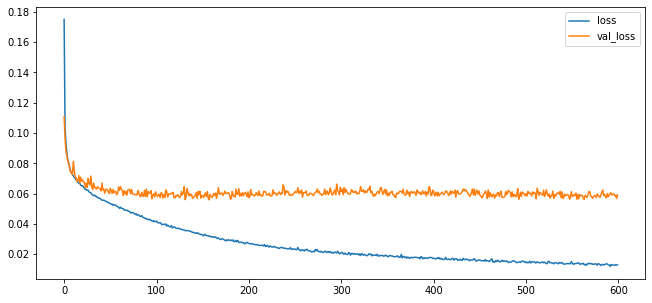


Epoch 00600: val_loss did not improve from 0.05591
12031/12031 [==============================] - 13s 1ms/sample - loss: 0.0129 - Output_head_loss: 0.0068 - Output_orientation_loss: 0.0061 - val_loss: 0.0592 - val_Output_head_loss: 0.0098 - val_Output_orientation_loss: 0.0494


In [18]:
size = [(10,9),8,160,80,160,2,4]
lr = 0.0003
epochs = 600

for i in range(0,1) :
    save_path = './SaveModels/Modified_Models/Model2_difftime_{}.h'.format(i)

    _model1 = model_LSTM(size)
    Model1,history1 = TrainModel(_model = _model1,save_path = save_path, lr = lr,epochs=epochs,
    #                             losses = ['mean_squared_error'],
                                 losses = [euclidean_distance_loss,'mean_squared_error'],
                                 train_x = x_train, train_y =y_train,
                                val_x = x_val, val_y =y_val )


# Model3 : using 3 teammates

### inputs

In [ ]:
path = './Data_v2.0/5Robots/TrainSet'
data_train = pd.read_csv(path+'/Train.csv')
data_test = pd.read_csv(path+'/Test.csv')
data_val = pd.read_csv(path+'/Val.csv')

robots = ['H','F1','F2','F3','T']
std_robot = 'T'
coordinates = ['x','y']
orientation = ['o']


In [ ]:
train_data = s_relative_and_std(data = data_train, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F3','F2'])
val_data = s_relative_and_std(data = data_val, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F3','F2'])
test_data = s_relative_and_std(data = data_test, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F3','F2'])

In [ ]:
_obs_list = ['_F3_x','_F3_y','_T_o','_F2_x','_F2_y','_F1_x','_F1_y']
pred_list = ['_H_x','_H_y','_H_o','_F1_o','_F2_o','_F3_o']
#_obs_list = ['_F1_x','_F1_y','_T_o']
# !!!!!!!!!!!!!!!!!!!!!!!! '_T_o' 추가 필요 !!!!!!!!!!!!!!!!
#pred_list = ['_H_x','_H_y','_H_o','_F1_o','_F2_o','_F3_o']
step = 0
x_train = set_input(_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = train_data,data2 = train_data)
x_val = set_input(_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = val_data,data2 = val_data)
x_test = set_input(_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = test_data,data2 = test_data)

### labels

In [ ]:
_label_list = [['{}_H_x'.format(_n_hist),'{}_H_y'.format(_n_hist)],
            ['{}_H_o'.format(_n_hist),'{}_F1_o'.format(_n_hist),'{}_F2_o'.format(_n_hist),'{}_F3_o'.format(_n_hist)]]

#_label_list = [['{}_H_x'.format(_n_hist),'{}_H_y'.format(_n_hist)],
#            ['{}_H_o'.format(_n_hist),'{}_F1_o'.format(_n_hist)]]

y_train = s_labels(_label_list = _label_list, data = train_data)
y_val = s_labels(_label_list = _label_list, data = val_data)
y_test = s_labels(_label_list = _label_list, data = test_data)

In [ ]:
size = [(10,9),6,30,10,10,50,30,2,2]
lr = 0.00025
epochs = 500

for i in range(0,5) :
    save_path = './SaveModels/Test/Model3_{}.h'.format(i)

    _model1 = model_LSTM(size)
    Model1,history1 = TrainModel(_model = _model1,save_path = save_path, lr = lr,epochs=epochs,
    #                             losses = ['mean_squared_error'],
                                 losses = [euclidean_distance_loss,'mean_squared_error'],
                                 train_x = x_train, train_y =y_train,
                                val_x = x_val, val_y =y_val )


# Model3_2 : Model3 + different time step

In [19]:
std_coordinates = 400
std_orientation = 180

_n_hist = 10
_n_samples = 14

### inputs

In [20]:
path = './Data_v2.0/5Robots/TrainSet_2'
data_train = pd.read_csv(path+'/Train.csv')
data_test = pd.read_csv(path+'/Test.csv')
data_val = pd.read_csv(path+'/Val.csv')

robots = ['H','F1','F2','F3','T']
std_robot = 'T'
coordinates = ['x','y']
orientation = ['o']


In [21]:
_max = 0
for i in range(_n_samples) :
    _tmp = np.max(np.abs(data_train['{}_H_y'.format(i)]-data_train['{}_T_y'.format(i)]))
    if _tmp >= _max :
        _max = _tmp
print(_max)

382


In [22]:
train_data = s_relative_and_std(data = data_train, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F2','F3'])
val_data = s_relative_and_std(data = data_val, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F2','F3'])
test_data = s_relative_and_std(data = data_test, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1','F2','F3'])

In [23]:
_obs_list = ['_F3_x','_F3_y','_F2_x','_F2_y','_F1_x','_F1_y']
pred_list = ['_H_x','_H_y','_H_o','_F1_o','_F2_o','_F3_o']
step = 0
x_train = set_input(timedifference=[2,2,1,1,0,0],_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = train_data,data2 = train_data)
x_val = set_input(timedifference=[2,2,1,1,0,0],_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = val_data,data2 = val_data)
x_test = set_input(timedifference=[2,2,1,1,0,0],_obs_list = _obs_list, pred_list= pred_list,step = step,  _hist_len = _n_hist,_n_samples = _n_samples, data1 = test_data,data2 = test_data)

History : [['0_F3_x', '0_F3_y', '0_F2_x', '0_F2_y', '0_F1_x', '0_F1_y'], ['0_H_x', '0_H_y', '0_H_o', '0_F1_o', '0_F2_o', '0_F3_o'], []]
History : [['1_F3_x', '1_F3_y', '1_F2_x', '1_F2_y', '1_F1_x', '1_F1_y'], ['1_H_x', '1_H_y', '1_H_o', '1_F1_o', '1_F2_o', '1_F3_o'], []]
History : [['2_F3_x', '2_F3_y', '2_F2_x', '2_F2_y', '2_F1_x', '2_F1_y'], ['2_H_x', '2_H_y', '2_H_o', '2_F1_o', '2_F2_o', '2_F3_o'], []]
History : [['3_F3_x', '3_F3_y', '3_F2_x', '3_F2_y', '3_F1_x', '3_F1_y'], ['3_H_x', '3_H_y', '3_H_o', '3_F1_o', '3_F2_o', '3_F3_o'], []]
History : [['4_F3_x', '4_F3_y', '4_F2_x', '4_F2_y', '4_F1_x', '4_F1_y'], ['4_H_x', '4_H_y', '4_H_o', '4_F1_o', '4_F2_o', '4_F3_o'], []]
History : [['5_F3_x', '5_F3_y', '5_F2_x', '5_F2_y', '5_F1_x', '5_F1_y'], ['5_H_x', '5_H_y', '5_H_o', '5_F1_o', '5_F2_o', '5_F3_o'], []]
History : [['6_F3_x', '6_F3_y', '6_F2_x', '6_F2_y', '6_F1_x', '6_F1_y'], ['6_H_x', '6_H_y', '6_H_o', '6_F1_o', '6_F2_o', '6_F3_o'], []]
History : [['7_F3_x', '7_F3_y', '7_F2_x', '7_F2_

### labels

In [24]:
_label_list = [['{}_H_x'.format(_n_hist),'{}_H_y'.format(_n_hist)],
            ['{}_H_o'.format(_n_hist),'{}_F1_o'.format(_n_hist),'{}_F2_o'.format(_n_hist),'{}_F3_o'.format(_n_hist),'{}_F3_o'.format(_n_hist+1)]]

y_train = s_labels(_label_list = _label_list, data = train_data)
y_val = s_labels(_label_list = _label_list, data = val_data)
y_test = s_labels(_label_list = _label_list, data = test_data)

In [25]:
print(_label_list)

[['10_H_x', '10_H_y'], ['10_H_o', '10_F1_o', '10_F2_o', '10_F3_o', '11_F3_o']]


### Training

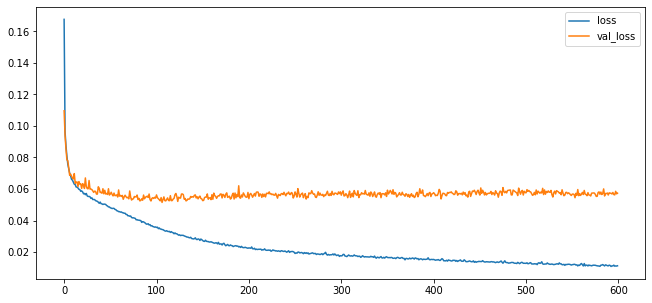


Epoch 00600: val_loss did not improve from 0.05149
11048/11048 [==============================] - 12s 1ms/sample - loss: 0.0113 - Output_head_loss: 0.0056 - Output_orientation_loss: 0.0057 - val_loss: 0.0574 - val_Output_head_loss: 0.0087 - val_Output_orientation_loss: 0.0487


In [26]:
size = [(10,12),12,160,80,160,2,5]
lr = 0.0003
epochs = 600

for i in range(0,1) :
    save_path = './SaveModels/Modified_Models/Model3_difftime_{}.h'.format(i)

    _model1 = model_LSTM(size)
    Model1,history1 = TrainModel(_model = _model1,save_path = save_path, lr = lr,epochs=epochs,
    #                             losses = ['mean_squared_error'],
                                 losses = [euclidean_distance_loss,'mean_squared_error'],
                                 train_x = x_train, train_y =y_train,
                                val_x = x_val, val_y =y_val )
